(pystan2_refitting_xr)=
# Refitting PyStan (2.x) models with ArviZ (and xarray)

ArviZ is backend agnostic and therefore does not sample directly. In order to take advantage of algorithms that require refitting models several times, ArviZ uses {class}`~arviz.SamplingWrapper`s to convert the API of the sampling backend to a common set of functions. Hence, functions like Leave Future Out Cross Validation can be used in ArviZ independently of the sampling backend used.

Below there is one example of `SamplingWrapper` usage for PyStan (2.x).

In [1]:
import arviz as az
import pystan
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import xarray as xr

For the example we will use a linear regression.

In [2]:
np.random.seed(26)

xdata = np.linspace(0, 50, 100)
b0, b1, sigma = -2, 1, 3
ydata = np.random.normal(loc=b1 * xdata + b0, scale=sigma)

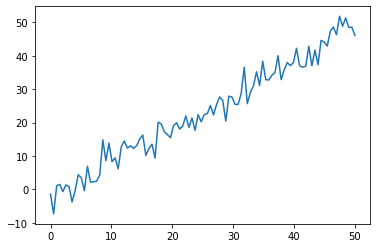

In [3]:
plt.plot(xdata, ydata)

Now we will write the Stan code, keeping in mind only to include the array shapes as parameters.

In [4]:
refit_lr_code = """
data {
  // Define data for fitting
  int<lower=0> N;
  vector[N] x;
  vector[N] y;
}

parameters {
  real b0;
  real b1;
  real<lower=0> sigma_e;
}

model {
  b0 ~ normal(0, 10);
  b1 ~ normal(0, 10);
  sigma_e ~ normal(0, 10);
  for (i in 1:N) {
    y[i] ~ normal(b0 + b1 * x[i], sigma_e);  // use only data for fitting
  }
  
}

generated quantities {
    vector[N] y_hat;
    
    for (i in 1:N) {
        // pointwise log likelihood will be calculated outside Stan, 
        // posterior predictive however will be generated here, there are 
        // no restrictions on adding more generated quantities
        y_hat[i] = normal_rng(b0 + b1 * x[i], sigma_e);
    }
}
"""

In [5]:
sm = pystan.StanModel(model_code=refit_lr_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2cdc9d1f1db425bb7186f919c45c9b36 NOW.


In [6]:
data_dict = {
    "N": len(ydata),
    "y": ydata,
    "x": xdata,
}
sample_kwargs = {"iter": 1000, "chains": 4}
fit = sm.sampling(data=data_dict, **sample_kwargs)

We have defined a dictionary `sample_kwargs` that will be passed to the `SamplingWrapper` in order to make sure that all
refits use the same sampler parameters. We follow the same pattern with {func}`~arviz.from_pystan`.

In [7]:
dims = {"y": ["time"], "x": ["time"], "y_hat": ["time"]}
idata_kwargs = {
    "posterior_predictive": ["y_hat"],
    "observed_data": "y",
    "constant_data": "x",
    "dims": dims,
}
idata = az.from_pystan(posterior=fit, **idata_kwargs)

We are now missing the `log_likelihood` group because we have not used the `log_likelihood` argument in `idata_kwargs`. We are doing this to ease the job of the sampling wrapper. Instead of going out of our way to get Stan to calculate the pointwise log likelihood values for each refit and for the excluded observation at every refit, we will compromise and manually write a function to calculate the pointwise log likelihood.

Even though it is not ideal to lose part of the straight out of the box capabilities of PyStan-ArviZ integration, this should generally not be a problem. We are basically moving the pointwise log likelihood calculation from the Stan code to the Python code, in both cases we need to manually write the function to calculate the pointwise log likelihood.

Moreover, the Python computation could even be written to be compatible with Dask. Thus it will work even in cases where the large number of observations makes it impossible to store pointwise log likelihood values (with shape `n_samples * n_observations`) in memory.

In [8]:
def calculate_log_lik(x, y, b0, b1, sigma_e):
    mu = b0 + b1 * x
    return stats.norm(mu, sigma_e).logpdf(y)

This function should work for any shape of the input arrays as long as their shapes are compatible and can broadcast. There is no need to loop over each draw in order to calculate the pointwise log likelihood using scalars.

Therefore, we can use `xr.apply_ufunc` to handle the broadasting and preserve the dimension names:

In [9]:
log_lik = xr.apply_ufunc(
    calculate_log_lik,
    idata.constant_data["x"],
    idata.observed_data["y"],
    idata.posterior["b0"],
    idata.posterior["b1"],
    idata.posterior["sigma_e"],
)
idata.add_groups(log_likelihood=log_lik)

The first argument is the function, followed by as many positional arguments as needed by the function, 5 in our case. As this case does not have many different dimensions nor combinations of these, we do not need to use any extra kwargs passed to {func}`xarray:xarray.apply_ufunc`.

We are now passing the arguments to `calculate_log_lik` initially as {class}`xarray:xarray.DataArray`s. What is happening here behind the scenes is that {func}`~xarray:xarray.apply_ufunc` is broadcasting and aligning the dimensions of all the DataArrays involved and afterwards passing numpy arrays to `calculate_log_lik`. Everything works automagically. 

Now let's see what happens if we were to pass the arrays directly to `calculate_log_lik` instead:

In [10]:
calculate_log_lik(
    idata.constant_data["x"].values,
    idata.observed_data["y"].values,
    idata.posterior["b0"].values,
    idata.posterior["b1"].values,
    idata.posterior["sigma_e"].values
)

ValueError: operands could not be broadcast together with shapes (4,500) (100,) 

If you are still curious about the magic of xarray and {func}`~xarray:xarray.apply_ufunc`, you can also try to modify the `dims` used to generate the InferenceData a couple cells before:

    dims = {"y": ["time"], "x": ["time"]}
    
What happens to the result if you use a different name for the dimension of `x`?

In [11]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data
	> log_likelihood

We will create a subclass of {class}`~arviz.SamplingWrapper`. Therefore, instead of having to implement all functions required by {func}`~arviz.reloo` we only have to implement `sel_observations` (we are cloning `sample` and `get_inference_data` from the `PyStan2SamplingWrapper` in order to use `apply_ufunc` instead of assuming the log likelihood is calculated within Stan). 

Note that of the 2 outputs of `sel_observations`, `data__i` is a dictionary because it is an argument of `sample` which will pass it as is to `model.sampling`, whereas `data_ex` is a list because it is an argument to `log_likelihood__i` which will pass it as `*data_ex` to  `apply_ufunc`. More on `data_ex` and `apply_ufunc` integration below.

In [ ]:
class LinearRegressionWrapper(az.SamplingWrapper):
    def sel_observations(self, idx):
        xdata = self.idata_orig.constant_data["x"]
        ydata = self.idata_orig.observed_data["y"]
        mask = np.isin(np.arange(len(xdata)), idx)
        data__i = {"x": xdata[~mask], "y": ydata[~mask], "N": len(ydata[~mask])}
        data_ex = [ary[mask] for ary in (xdata, ydata)]
        return data__i, data_ex
    
    def sample(self, modified_observed_data):
        #Cloned from PyStan2SamplingWrapper.
        fit = self.model.sampling(data=modified_observed_data, **self.sample_kwargs)
        return fit

    def get_inference_data(self, fit):
        # Cloned from PyStanSamplingWrapper.
        idata = az.from_pystan(posterior=fit, **self.idata_kwargs)
        return idata


In [13]:
loo_orig = az.loo(idata, pointwise=True)
loo_orig

Computed from 2000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo  -250.79     7.12
p_loo        2.95        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In this case, the Leave-One-Out Cross Validation (LOO-CV) approximation using Pareto Smoothed Importance Sampling (PSIS) works for all observations, so we will use modify `loo_orig` in order to make {func}`~arviz.reloo` believe that PSIS failed for some observations. This will also serve as a validation of our wrapper, as the PSIS LOO-CV already returned the correct value.

In [14]:
loo_orig.pareto_k[[13, 42, 56, 73]] = np.array([0.8, 1.2, 2.6, 0.9])

We initialize our sampling wrapper. Let's stop and analyze each of the arguments. 

We then use the `log_lik_fun` and `posterior_vars` argument to tell the wrapper how to call {func}`~xarray:xarray.apply_ufunc`. `log_lik_fun` is the function to be called, which is then called with the following positional arguments:

    log_lik_fun(*data_ex, *[idata__i.posterior[var_name] for var_name in posterior_vars]
    
where `data_ex` is the second element returned by `sel_observations` and `idata__i` is the InferenceData object result of `get_inference_data` which contains the fit on the subsetted data. We have generated `data_ex` to be a tuple of DataArrays so it plays nicely with this call signature.

We use `idata_orig` as a starting point, and mostly as a source of observed and constant data which is then subsetted in `sel_observations`.

Finally, `sample_kwargs` and `idata_kwargs` are used to make sure all refits and corresponding InferenceData are generated with the same properties.

In [15]:
pystan_wrapper = LinearRegressionWrapper(
    sm, 
    log_lik_fun=calculate_log_lik, 
    posterior_vars=("b0", "b1", "sigma_e"),
    idata_orig=idata, 
    sample_kwargs=sample_kwargs, 
    idata_kwargs=idata_kwargs
)

And eventually, we can use this wrapper to call `az.reloo`, and compare the results with the PSIS LOO-CV results.

In [16]:
loo_relooed = az.reloo(pystan_wrapper, loo_orig=loo_orig)

/home/oriol/miniconda3/envs/arviz/lib/python3.8/site-packages/arviz/stats/stats_refitting.py:99: UserWarning: reloo is an experimental and untested feature
  warnings.warn("reloo is an experimental and untested feature", UserWarning)
arviz.stats.stats_refitting - INFO - Refitting model excluding observation 13
INFO:arviz.stats.stats_refitting:Refitting model excluding observation 13
arviz.stats.stats_refitting - INFO - Refitting model excluding observation 42
INFO:arviz.stats.stats_refitting:Refitting model excluding observation 42
arviz.stats.stats_refitting - INFO - Refitting model excluding observation 56
INFO:arviz.stats.stats_refitting:Refitting model excluding observation 56
arviz.stats.stats_refitting - INFO - Refitting model excluding observation 73
INFO:arviz.stats.stats_refitting:Refitting model excluding observation 73


In [17]:
loo_relooed

Computed from 2000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo  -250.79     7.12
p_loo        2.95        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [18]:
loo_orig

Computed from 2000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo  -250.79     7.12
p_loo        2.95        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       96   96.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         2    2.0%
   (1, Inf)   (very bad)    2    2.0%